# Text classification with a transformer language model using JAX

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_transformer_text_classification.ipynb)

This tutorial demonstrates how to build a text classifier using a transformer language model using JAX, [Flax NNX](http://flax.readthedocs.io) and [Optax](http://optax.readthedocs.io). We will perform sentiment analysis on movie reviews from the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb), classifying them as positive or negative.

Here, you will learn how to:

- Load and preprocess the dataset.
- Define the transformer model with Flax NNX and JAX.
- Create loss and training step functions.
- Train the model.
- Evaluate the model with an example.

If you are new to JAX for AI, check out the [introductory tutorial](https://jax-ai-stack.readthedocs.io/en/latest/neural_net_basics.html), which covers neural network building with [Flax NNX](https://flax.readthedocs.io/en/latest/nnx_basics.html).

## Setup

JAX installation is covered in [this guide](https://jax.readthedocs.io/en/latest/installation.html) on the JAX documentation site. We will use [Grain](https://google-grain.readthedocs.io/en/latest/index.html) for data loading, and [tqdm](https://tqdm.github.io/) for a progress bar to monitor the training progress.

In [1]:
# Required packages
# !pip install -U grain tqdm requests matplotlib

Import the necessary modules, including JAX NumPy, Flax NNX, Optax, Grain, tqdm, NumPy and matplotlib:

In [2]:
import io
import json
import textwrap
import typing

import jax
import jax.numpy as jnp
from flax import nnx
import optax
import grain.python as grain
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import requests

## Loading and preprocessing the data

### Loading the data

This section details loading, preprocessing, and preparing the [IMDB dataset](https://ai.stanford.edu/~amaas/data/sentiment/) movie review dataset.  The dataset contains 25,000 movie reviews from IMDB labeled by sentiment (positive/negative). Reviews are encoded as lists of word indices, where words are indexed by frequency. Positive and negative sentiments have integer labels 1 or 0, respectively.

Let's create two functions: `prepare_imdb_dataset()` that loads and prepares the dataset, and `pad_sequences()` for padding the (NumPy) array sequences to a fixed length:

In [3]:
def prepare_imdb_dataset(num_words: int, index_from: int, oov_char: int = 2) -> tuple:
    """Download and preprocess the IMDB dataset from TensorFlow Datasets.

    Args:
        num_words (int): The maximum number of words to keep in the vocabulary.
        index_from (int): The starting index for word indices.
        oov_char (int): The character to use for out-of-vocabulary words. Defaults to 2.

    Returns:
        A tuple containing the training and test sets with labels.
    """
    response = requests.get("https://storage.googleapis.com/tensorflow/tf-keras-datasets/imdb.npz")
    response.raise_for_status()

    # The training and test sets.
    with np.load(io.BytesIO(response.content), allow_pickle=True) as f:
        x_train, y_train = f["x_train"], f["y_train"]
        x_test, y_test = f["x_test"], f["y_test"]

    # Shuffle the training and test sets.
    rng = np.random.RandomState(113)
    indices = np.arange(len(x_train))
    rng.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]

    indices = np.arange(len(x_test))
    rng.shuffle(indices)
    x_test = x_test[indices]
    y_test = y_test[indices]

    # Adjust word indices to start from the specified index.
    x_train = [[w + index_from for w in x] for x in x_train]
    x_test = [[w + index_from for w in x] for x in x_test]

    # Combine training and test sets, then truncates/pads sequences.
    xs = x_train + x_test
    labels = np.concatenate([y_train, y_test])
    xs = [
        [w if w < num_words else oov_char for w in x] for x in xs
    ]

    idx = len(x_train)
    x_train, y_train = np.array(xs[:idx], dtype="object"), labels[:idx]
    x_test, y_test = np.array(xs[idx:], dtype="object"), labels[idx:]

    return (x_train, y_train), (x_test, y_test)

def pad_sequences(arrs: typing.Iterable, max_len: int) -> np.ndarray:
    """Pad array sequences to a fixed length.

    Args:
        arrs (typing.Iterable): A list of arrays.
        max_len (int): The desired maximum length.

    Returns:
        A NumPy array of padded sequences.
    """
    # Ensure that each sample is the same length
    result = []
    for arr in arrs:
        arr_len = len(arr)
        if arr_len < max_len:
            padded_arr = np.pad(arr, (max_len - arr_len, 0), 'constant', constant_values=0)
        else:
            padded_arr = np.array(arr[arr_len - max_len:])
        result.append(padded_arr)

    return np.asarray(result)

In [4]:
index_from = 3  # Ensures that 0 encodes the padding token.
vocab_size = 20000  # Considers only the top 20,000 words.
maxlen = 200  # Limits each review to the first 200 words.

# Instantiate the training and test sets.
(x_train, y_train), (x_test, y_test) = prepare_imdb_dataset(num_words=vocab_size, index_from=index_from)
print(len(x_train), "Training sequences")
print(len(x_test), "Validation sequences")

# Pad array sequences to a fixed length.
x_train = pad_sequences(x_train, max_len=maxlen)
x_test = pad_sequences(x_test, max_len=maxlen)

25000 Training sequences
25000 Validation sequences


## Apply efficient data loading and preprocessing using Grain

We will utilize the Grain library for efficient data loading and preprocessing. Grain supports custom setups where data sources may come in different forms, and in this tutorial we will implement the `grain.RandomAccessDataSource` (a Grain data source) interface. (To learn more, you can check out [PyGrain Data Sources](https://google-grain.readthedocs.io/en/latest/tutorials/data_sources/index.html).)

Our dataset is comprised of relatively small NumPy arrays, so the `grain.RandomAccessDataSource` is not complicated:

In [5]:
# Implement a custom data source for Grain to handle the IMDB dataset.
class DataSource(grain.RandomAccessDataSource):
    def __init__(self, x, y):
        self._x = x
        self._y = y

    def __getitem__(self, idx):
        return {"encoded_indices": self._x[idx], "label": self._y[idx]}

    def __len__(self):
        return len(self._x)

In [6]:
# Instantiate the training and test set data sources.
train_source = DataSource(x_train, y_train)
test_source = DataSource(x_test, y_test)

**Note:** We are using a single-device setup, so [device parallelism](https://docs.jax.dev/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization.html) or sharding for [Single-Program Multi-Data](https://en.wikipedia.org/wiki/Single_program,_multiple_data) is not needed in this example. During sharding, the training data is run via multiple parts - batches - in parallel and simultaneously across different devices, such as GPUs and Google TPUs, and larger batch sizes can speed up training. You can learn more about it in the [miniGPT with JAX tutorial](https://jax-ai-stack.readthedocs.io/en/latest/JAX_for_LLM_pretraining.html) and JAX documentation's [tensor parallelism](https://docs.jax.dev/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization.html) page.

In [7]:
# Set the batch sizes for the dataset.
seed = 12
train_batch_size = 128
test_batch_size = 2 * train_batch_size

# Define `grain.IndexSampler`s for training and testing data.
train_sampler = grain.IndexSampler(
    len(train_source),
    shuffle=True,
    seed=seed,
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup.
    num_epochs=1,                      # Iterate over the dataset for one epoch.
)

test_sampler = grain.IndexSampler(
    len(test_source),
    shuffle=False,
    seed=seed,
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup.
    num_epochs=1,                      # Iterate over the dataset for one epoch.
)


# Create `grain.DataLoader`s for training and test sets.
train_loader = grain.DataLoader(
    data_source=train_source,
    sampler=train_sampler,  # A `grain.IndexSampler` determining how to access the data.
    worker_count=4,         # The number of child processes launched to parallelize the transformations.
    worker_buffer_size=2,   # The number count of output batches to produce in advance per worker.
    operations=[
        grain.Batch(train_batch_size, drop_remainder=True),
    ]
)

test_loader = grain.DataLoader(
    data_source=test_source,
    sampler=test_sampler,  # A `grain.IndexSampler` to determine how to access the data.
    worker_count=4,        # The number of child processes launched to parallelize the transformations.
    worker_buffer_size=2,  # The number count of output batches to produce in advance per worker.
    operations=[
        grain.Batch(test_batch_size),
    ]
)

## Define the transformer model with Flax and JAX

In this section, we'll construct the transformer model using JAX and Flax NNX.

Let's begin with the transformer block, subclassing `flax.nnx.Module`. This class processes the embedded sequences.

In [8]:
class TransformerBlock(nnx.Module):
    """ A single Transformer block that processes the embedded sequences.

    Each Transformer block processes input sequences via self-attention and feed-forward networks.

    Args:
        embed_dim (int): Embedding dimensionality.
        num_heads (int): Number of attention heads.
        ff_dim (int): Dimensionality of the feed-forward network.
        rngs (flax.nnx.Rngs): A Flax NNX stream of JAX PRNG keys.
        rate (float): Dropout rate. Defaults to 0.1.
    """
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, rngs: nnx.Rngs, rate: float = 0.1):
        # Multi-Head Attention (MHA) using `flax.nnx.MultiHeadAttention`.
        # Specifies tensor sharding (depending on the mesh cofiguration).
        self.attention = nnx.MultiHeadAttention(
            num_heads=num_heads, in_features=embed_dim, qkv_features=embed_dim, decode=False, rngs=rngs
        )
        # First linear transformation for the feed-forward network using `flax.nnx.Linear`.
        self.dense_1 = nnx.Linear(in_features=embed_dim, out_features=ff_dim, rngs=rngs)
        # Second linear transformation for the feed-forward network with `flax.nnx.Linear`.
        self.dense_2 = nnx.Linear(in_features=ff_dim, out_features=ff_dim, rngs=rngs)

        # First layer normalization using `flax.nnx.LayerNorm`.
        self.layer_norm_1 = nnx.LayerNorm(num_features=embed_dim, epsilon=1e-6, rngs=rngs)
        # Second layer normalization with `flax.nnx.LayerNorm`.
        self.layer_norm_2 = nnx.LayerNorm(num_features=ff_dim, epsilon=1e-6, rngs=rngs)

        # First dropout using `flax.nnx.Dropout`.
        self.dropout_1 = nnx.Dropout(rate, rngs=rngs)
        # Second dropout using `flax.nnx.Dropout`.
        self.dropout_2 = nnx.Dropout(rate, rngs=rngs)

    # Apply the transformer block to the input sequence.
    def __call__(self, inputs: jax.Array):
        # Apply Multi-Head Attention.
        x = self.attention(inputs, inputs)
        # Apply the first dropout.
        x = self.dropout_1(x)
        # Apply the first layer normalization.
        x_norm_1 = self.layer_norm_1(inputs + x)
        # The feed-forward network.
        # Apply the first linear transformation.
        x = self.dense_1(x_norm_1)
        # Apply the ReLU activation with `jax.nnx.relu`.
        x = jax.nn.relu(x)
        # Apply the second linear transformation.
        x = self.dense_2(x)
        # Apply the second dropout.
        x = self.dropout_2(x)
        # Apply the second layer normalization and return the output of the Transformer block.
        x = self.layer_norm_2(x_norm_1 + x)
        return x

Next, let's create a class called `TokenAndPositionEmbedding()` that transforms tokens and positions into embeddings that will be fed into the transformer (via `TransformerBlock`) by subclassing `flax.nnx.Module`.

The `TokenAndPositionEmbedding()` class will combine token embeddings (words in an input sentence) with positional embeddings (the position of each word in a sentence). (It handles embedding both word tokens and their positions within the sequence.)

In [9]:
class TokenAndPositionEmbedding(nnx.Module):
    """ Combines token embeddings with positional embeddings.

    Args:
        maxlen (int): The maximum sequence length.
        vocal_size (int): The vocabulary size.
        embed_dim (int): Embedding dimensionality.
        rngs (flax.nnx.Rngs): A Flax NNX stream of JAX PRNG keys.
    """

    # Initializes the token embedding layer (using `flax.nnx.Embed`).
    # Handles token and positional embeddings.
    def __init__(self, max_length: int, vocab_size: int, embed_dim: int, rngs: nnx.Rngs):
        # Each unique word has an embedding vector.
        self.token_emb = nnx.Embed(num_embeddings=vocab_size, features=embed_dim, rngs=rngs)
        # Initialize positional embeddings (using `flax.nnx.Embed`).
        self.pos_emb = nnx.Embed(num_embeddings=max_length, features=embed_dim, rngs=rngs)

    # Generates embeddings for the input tokens and their positions.
    # Takes a token sequence (integers) and returns the combined token and positional embeddings.
    def __call__(self, x: jax.Array):
        maxlen = jnp.shape(x)[-1]
        # Generate a sequence of positions for the input tokens.
        positions = jnp.arange(start=0, stop=maxlen, step=1)
        # Look up the positional embeddings for each position in the input sequence.
        positions = self.pos_emb(positions)
        # Look up the token embeddings for each token in the input sequence.
        x = self.token_emb(x)
        # Combine token and positional embeddings.
        return x + positions

Next, we'll construct the transformer model, `MyModel()`, subclassing `flax.nnx.Module`, which includes `TokenAndPositionEmbedding()` for transforming tokens and positions into embeddings, transformer blocks (`TransformerBlock()`) for processing the embedded sequences, and other layers.

In [10]:
embed_dim = 32  # The embedding size for each token.
num_heads = 2  # The number of attention heads.
ff_dim = 32  # The hidden layer size in the feed-forward network inside the transformer.

class MyModel(nnx.Module):
    def __init__(self, rngs: nnx.Rngs):
        """ Initializes the transformer block with the `TokenAndPositionEmbedding()`,
        `TransformerBlock()`, and other layers.

        Args:
            rngs (flax.nnx.Rngs): A Flax NNX stream of JAX PRNG keys.
        """

        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim, rngs=rngs)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, rngs=rngs)
        self.dropout1 = nnx.Dropout(0.1, rngs=rngs)
        self.dense1 = nnx.Linear(in_features=embed_dim, out_features=20, rngs=rngs)
        self.dropout2 = nnx.Dropout(0.1, rngs=rngs)
        self.dense2 = nnx.Linear(in_features=20, out_features=2, rngs=rngs)

    # Processes the input sequence through the transformer model.
    def __call__(self, x: jax.Array):
        x = self.embedding_layer(x)
        x = self.transformer_block(x)
        x = jnp.mean(x, axis=(1,))  # global average pooling
        x = self.dropout1(x)
        x = self.dense1(x)
        x = jax.nn.relu(x)
        x = self.dropout2(x)
        x = self.dense2(x)
        x = jax.nn.softmax(x)
        return x

Instantiate the model, `MyModel()`, as `model` and visualize it by calling `flax.nnx.display()`:

In [11]:
model = MyModel(rngs=nnx.Rngs(0))
nnx.display(model)

MyModel(
  embedding_layer=TokenAndPositionEmbedding(
    token_emb=Embed(
      embedding=Param(
        value=Array(shape=(20000, 32), dtype=float32)
      ),
      num_embeddings=20000,
      features=32,
      dtype=dtype('float32'),
      param_dtype=<class 'jax.numpy.float32'>,
      embedding_init=<function variance_scaling.<locals>.init at 0x7f0cab141e10>
    ),
    pos_emb=Embed(
      embedding=Param(
        value=Array(shape=(200, 32), dtype=float32)
      ),
      num_embeddings=200,
      features=32,
      dtype=dtype('float32'),
      param_dtype=<class 'jax.numpy.float32'>,
      embedding_init=<function variance_scaling.<locals>.init at 0x7f0cab141e10>
    )
  ),
  transformer_block=TransformerBlock(
    attention=MultiHeadAttention(
      num_heads=2,
      in_features=32,
      qkv_features=32,
      out_features=32,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      broadcast_dropout=True,
      dropout_rate=0.0,
      deterministic=None,
      

## Defining the loss function and training step-related functions

Before training the model, we need to construct an `flax.nnx.Optimizer` object with our `MyModel` transformer and the Adam optimizer.

In [12]:
num_epochs = 10 # Number of epochs during training.
learning_rate = 0.0001 # The learning rate.
momentum = 0.9 # Momentum for Adam.

optimizer = nnx.Optimizer(model, optax.adam(learning_rate, momentum))

Next, we define the loss function - `compute_losses_and_logits()` - using `optax.softmax_cross_entropy_with_integer_labels`:

In [13]:
def compute_losses_and_logits(model: nnx.Module, batch_tokens: jax.Array, labels: jax.Array):
    logits = model(batch_tokens)

    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=labels
    ).mean()
    return loss, logits

Next, let's define the training step - `train_step()` - using the `flax.nnx.jit` transformation decorator. The function takes in `model` (our transformer model), `optimizer` (Adam, as defined earlier) and the `batch` size as arguments. Then, let's define the evaluation step function (`eval_step()`), which takes `model`, `batch` and `eval_metrics` (loss and accuracy - details further below) as arguments.

In [14]:
@nnx.jit
def train_step(
    model: nnx.Module, optimizer: nnx.Optimizer, batch: dict[str, jax.Array]
):
    batch_tokens = jnp.array(batch["encoded_indices"])
    labels = jnp.array(batch["label"], dtype=jnp.int32)

    grad_fn = nnx.value_and_grad(compute_losses_and_logits, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch_tokens, labels)

    optimizer.update(grads)  # In-place updates.

    return loss

@nnx.jit
def eval_step(
    model: nnx.Module, batch: dict[str, jax.Array], eval_metrics: nnx.MultiMetric
):
    batch_tokens = jnp.array(batch["encoded_indices"])
    labels = jnp.array(batch["label"], dtype=jnp.int32)
    loss, logits = compute_losses_and_logits(model, batch_tokens, labels)

    eval_metrics.update(
        loss=loss,
        logits=logits,
        labels=labels,
    )

For metrics, let's set the evaluation metrics using `flax.nnx.MultiMetric`.

In [15]:
eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Accuracy(),
)

train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "test_loss": [],
    "test_accuracy": [],
}

Next, set up a function called `train_one_epoch()` for training one epoch, and a function called `evaluate_model()` for computing metrics on the training and test sets:

In [16]:
bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"
train_total_steps = len(x_train) // train_batch_size

def train_one_epoch(epoch):
    model.train()
    with tqdm.tqdm(
        desc=f"[train] epoch: {epoch}/{num_epochs}, ",
        total=train_total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        for batch in train_loader:
            loss = train_step(model, optimizer, batch)
            train_metrics_history["train_loss"].append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)


def evaluate_model(epoch):
    # Compute the metrics on the training and test sets after each training epoch.
    model.eval()

    eval_metrics.reset()  # Reset the eval metrics
    for test_batch in test_loader:
        eval_step(model, test_batch, eval_metrics)

    for metric, value in eval_metrics.compute().items():
        eval_metrics_history[f'test_{metric}'].append(value)

    print(f"[test] epoch: {epoch + 1}/{num_epochs}")
    print(f"- total loss: {eval_metrics_history['test_loss'][-1]:0.4f}")
    print(f"- Accuracy: {eval_metrics_history['test_accuracy'][-1]:0.4f}")

## Training the model

Train the model over 10 epochs:

In [17]:
%%time
for epoch in range(num_epochs):
    train_one_epoch(epoch)
    evaluate_model(epoch)

[train] epoch: 0/10, [192/195], loss=0.693 [00:36<00:00]


[test] epoch: 1/10
- total loss: 0.6879
- Accuracy: 0.5661


[train] epoch: 1/10, [192/195], loss=0.678 [00:35<00:00]


[test] epoch: 2/10
- total loss: 0.6734
- Accuracy: 0.6507


[train] epoch: 2/10, [192/195], loss=0.594 [00:35<00:00]


[test] epoch: 3/10
- total loss: 0.6177
- Accuracy: 0.7316


[train] epoch: 3/10, [192/195], loss=0.511 [00:35<00:00]


[test] epoch: 4/10
- total loss: 0.5404
- Accuracy: 0.7890


[train] epoch: 4/10, [192/195], loss=0.466 [00:35<00:00]


[test] epoch: 5/10
- total loss: 0.4995
- Accuracy: 0.8159


[train] epoch: 5/10, [192/195], loss=0.463 [00:35<00:00]


[test] epoch: 6/10
- total loss: 0.4806
- Accuracy: 0.8280


[train] epoch: 6/10, [192/195], loss=0.435 [00:35<00:00]


[test] epoch: 7/10
- total loss: 0.4714
- Accuracy: 0.8349


[train] epoch: 7/10, [192/195], loss=0.421 [00:35<00:00]


[test] epoch: 8/10
- total loss: 0.4665
- Accuracy: 0.8394


[train] epoch: 8/10, [192/195], loss=0.409 [00:35<00:00]


[test] epoch: 9/10
- total loss: 0.4602
- Accuracy: 0.8453


[train] epoch: 9/10, [192/195], loss=0.389 [00:35<00:00]


[test] epoch: 10/10
- total loss: 0.4560
- Accuracy: 0.8486
CPU times: user 27min 44s, sys: 12min 14s, total: 39min 59s
Wall time: 8min 19s


Let's visualize the training loss:

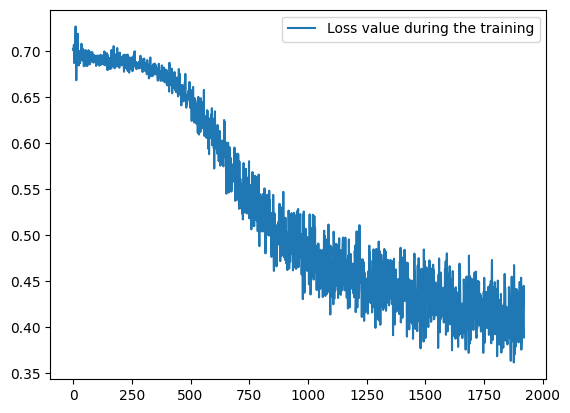

In [18]:
plt.plot(train_metrics_history["train_loss"], label="Loss value during the training")
plt.legend()

We can also plot the accuracy and loss metrics on the test set:

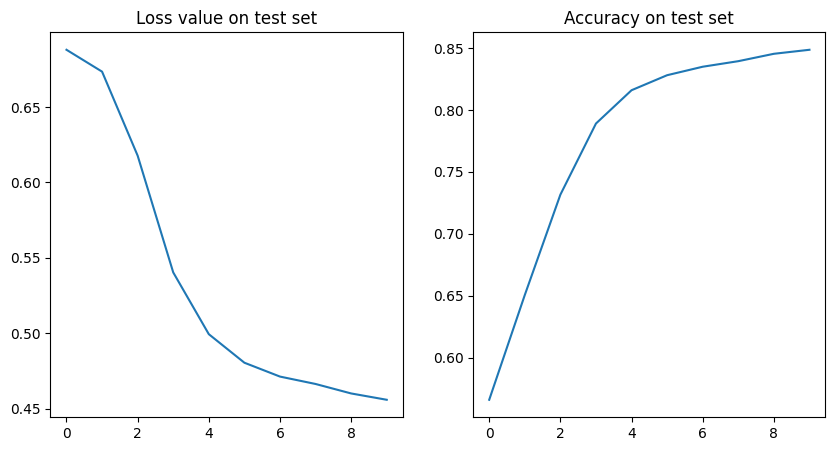

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title("Loss value on test set")
axs[0].plot(eval_metrics_history["test_loss"])
axs[1].set_title("Accuracy on test set")
axs[1].plot(eval_metrics_history["test_accuracy"])

The model achieves around 85% accuracy after just 10 epochs. Based on the loss plot, during the last few epochs the loss value didn't improve much, which may indicate that our model converged.

## Evaluate the model

To inspect the model using a few predictions, let's download "indices to words" dictionary to decode our samples. Then we will decode a few samples and print them together with a prediced and an actual label.

In [20]:
response = requests.get("https://storage.googleapis.com/tensorflow/tf-keras-datasets/imdb_word_index.json")
response.raise_for_status()
word_map = {v: k for k, v in json.loads(response.content).items()}

In [21]:
def _label_to_str(label: int) -> str:
    return "positive" if label else "negative"

def show_reviews(indices: list[int]) -> None:
    for idx in indices:
        x = x_test[idx][x_test[idx] != 0]
        y = y_test[idx]
        y_pred = model(x_test[idx][None, :]).argmax()
        review = ""
        for w_x in x:
            idx = w_x - index_from if w_x >= index_from else w_x
            review += f"{word_map[idx]} "

        print("Review:")
        for line in textwrap.wrap(review):
            print(line)
        print("Predicted sentiment: ", _label_to_str(y_pred))
        print("Actual sentiment: ", _label_to_str(y), "\n")

In [22]:
show_reviews([0, 500, 600, 1000, 1800, 2000])

Review:
please give this one a miss br br kristy swanson and the rest of the
cast rendered terrible performances the show is flat flat flat br br i
don't know how michael madison could have allowed this one on his
plate he almost seemed to know this wasn't going to work out and his
performance was quite lacklustre so all you madison fans give this a
miss
Predicted sentiment:  negative
Actual sentiment:  negative 

Review:
this is a funny movie the bob eddie show feel of it could lead to a
sequel but i doubt it will make enough money br br deniro proves he
can be a great straight man again with some hilarious and spontaneous
moments eddie was fun to watch working with people instead of cgi
animals and and rene russo well she's just fun to watch anyway and
she's played her part excellent br br some wild and unusual stunts
especially the garbage truck scene this was worth seeing in the
theater we needed a good laugh and got many from the movie and the
great out takes at the end do not lea